## EMOUERJ DATA PROCESSING

In [ ]:
cd drive/MyDrive/emoUERJ/

/content/drive/MyDrive/emoUERJ


In [ ]:
%%capture
!pip install webrtcvad
!pip install pydub

In [ ]:
import os
import librosa
import numpy as np
wav_files = os.listdir()


In [ ]:
emo_map = {'a': 1, 's': 2, 'n': 0, 'h': 3}
def get_sections(wav_file: str):
    speaker_id = wav_file[:3]
    emotion = emo_map[wav_file[3]]
    audio, sr = librosa.load(wav_file, sr=16000)
    return {
        'speaker_id': speaker_id,
        'label': emotion,
        'audio': {
            'path': wav_file,
            'array': list(audio),
            'sampling_rate': sr
        }
    }

In [ ]:
from tqdm import tqdm
samples = []
for wav_file in tqdm(wav_files):
    samples.append(get_sections(wav_file))

100%|██████████| 377/377 [00:09<00:00, 39.73it/s]


In [ ]:
from datasets import Dataset, Features
dataset = Dataset.from_list(samples)
dataset

Dataset({
    features: ['speaker_id', 'label', 'audio'],
    num_rows: 377
})

In [ ]:
speaker_ids = set(dataset['speaker_id'])
speaker_ids = list(speaker_ids)
speaker_ids

['m04', 'w01', 'w04', 'w03', 'm02', 'm03', 'w02', 'm01']

In [ ]:
from datasets import Audio, ClassLabel
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.cast_column("label", ClassLabel(num_classes=4))
dataset = dataset.cast_column("speaker_id", ClassLabel(num_classes=8,names=speaker_ids))
dataset.features

Casting the dataset:   0%|          | 0/377 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/377 [00:00<?, ? examples/s]

{'speaker_id': ClassLabel(names=['m04', 'w01', 'w04', 'w03', 'm02', 'm03', 'w02', 'm01'], id=None),
 'label': ClassLabel(names=['0', '1', '2', '3'], id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}

In [ ]:
import random
import numpy as np
import webrtcvad
from pydub import AudioSegment
from datasets import Dataset
from collections import deque

FRAME_DURATION_MS = 30
PADDING_DURATION_MS = 30
AGGRESSIVENESS = 2

class Frame:
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset+n], timestamp, duration)
        timestamp += duration
        offset += n

def vad_collector(sample_rate, frame_duration_ms, padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = deque(maxlen=num_padding_frames)
    triggered = False
    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, s in ring_buffer if s])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                for f, _ in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, s in ring_buffer if not s])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                yield b"".join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if voiced_frames:
        yield b"".join([f.bytes for f in voiced_frames])

def apply_vad(array, sr):
    pcm16 = (array * 32767).astype(np.int16).tobytes()
    vad = webrtcvad.Vad(AGGRESSIVENESS)
    frames = list(frame_generator(FRAME_DURATION_MS, pcm16, sr))
    segments = vad_collector(sr, FRAME_DURATION_MS, PADDING_DURATION_MS, vad, frames)
    voiced = b"".join(segments)
    return np.frombuffer(voiced, np.int16).astype(np.float32) / 32767.0

combinations = ["neu_emo","emo_neu","neu_emo_neu","emo_emo"]
probabilities = np.array([0.25,0.25,0.25,0.25])

def prepare_sed_dataset(utterance_ds, speaker_field=None, seed=123):
    random.seed(seed)
    processed = []
    for ex in utterance_ds:
        emo = ex["label"]
        if emo is None:
            continue
        spk = ex[speaker_field] if speaker_field and speaker_field in ex else "all"
        arr, sr = ex["audio"]["array"], ex["audio"]["sampling_rate"]
        arr = apply_vad(arr, sr)
        ints = (arr * 32767).astype(np.int16)
        seg = AudioSegment(ints.tobytes(), sample_width=2, frame_rate=sr, channels=1)
        processed.append({"seg": seg, "emotion": emo, "speaker": spk})

    groups = {}
    for item in processed:
        groups.setdefault(item["speaker"], []).append(item)

    records = []
    for spk, items in groups.items():
        emo_items = [i for i in items if i["emotion"]!="neu"]
        neu_items = [i for i in items if i["emotion"]=="neu"] * 10
        random.shuffle(emo_items)
        random.shuffle(neu_items)
        idx = 0
        while emo_items:
            combo = random.choices(combinations, probabilities)[0]
            if combo=="neu_emo":
                n = neu_items.pop(0); e = emo_items.pop(0)
                e_seg = e["seg"].apply_gain(n["seg"].dBFS - e["seg"].dBFS)
                comb = n["seg"] + e_seg
                events = [{"emo": e["emotion"], "start": n["seg"].duration_seconds, "end": comb.duration_seconds}]
            elif combo=="emo_neu":
                e = emo_items.pop(0); n = neu_items.pop(0)
                n_seg = n["seg"].apply_gain(e["seg"].dBFS - n["seg"].dBFS)
                comb = e["seg"] + n_seg
                events = [{"emo": e["emotion"], "start": 0, "end": e["seg"].duration_seconds}]
            elif combo=="neu_emo_neu":
                n1 = neu_items.pop(0); e = emo_items.pop(0); n2 = neu_items.pop(0)
                e_seg = e["seg"].apply_gain(n1["seg"].dBFS - e["seg"].dBFS)
                n2_seg = n2["seg"].apply_gain(n1["seg"].dBFS - n2["seg"].dBFS)
                comb = n1["seg"] + e_seg + n2_seg
                start = n1["seg"].duration_seconds
                events = [{"emo": e["emotion"], "start": start, "end": start + e_seg.duration_seconds}]
            else:
                e = emo_items.pop(0)
                comb = e["seg"]
                events = [{"emo": e["emotion"], "start": 0, "end": comb.duration_seconds}]

            samples = np.array(comb.get_array_of_samples(), dtype=np.int16)
            array = samples.astype(np.float32) / 32767.0
            records.append({
                "id":        f"{spk}_{idx}",
                "audio":     {"array": array, "sampling_rate": comb.frame_rate},
                "duration":  comb.duration_seconds,
                "emotion":   events
            })
            idx += 1

    return Dataset.from_list(records)

In [ ]:
from datasets import concatenate_datasets
CLASS_NAMES = ['neu', 'ang', 'sad', 'hap']
LABEL_MAP = dict(zip(CLASS_NAMES, range(len(CLASS_NAMES))))
id2label = {v:k for k,v in LABEL_MAP.items()}
sed_ds = prepare_sed_dataset(dataset, id2label, speaker_field='speaker_id', seed=42)
sed_ds

Dataset({
    features: ['id', 'audio', 'duration', 'emotion'],
    num_rows: 285
})

In [ ]:
from datasets import Audio, ClassLabel
sed_ds = sed_ds.cast_column("audio", Audio(sampling_rate=16000))
sed_ds.features

{'id': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'duration': Value(dtype='float64', id=None),
 'emotion': [{'emo': Value(dtype='string', id=None),
   'end': Value(dtype='float64', id=None),
   'start': Value(dtype='float64', id=None)}]}

In [ ]:
final_ds = sed_ds.train_test_split(0.3)
final_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'audio', 'duration', 'emotion'],
        num_rows: 199
    })
    test: Dataset({
        features: ['id', 'audio', 'duration', 'emotion'],
        num_rows: 86
    })
})

In [ ]:
final_ds.push_to_hub('emouerj-sed')

In [ ]:
sed_ds.cast_column

{'id': Value(dtype='string', id=None),
 'audio': {'array': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
  'sampling_rate': Value(dtype='int64', id=None)},
 'duration': Value(dtype='float64', id=None),
 'emotion': [{'emo': Value(dtype='string', id=None),
   'end': Value(dtype='float64', id=None),
   'start': Value(dtype='float64', id=None)}]}

## EMOUERJ EXPERIMENT

In [ ]:
%%capture
!pip install -U datasets

In [ ]:
cd /content/drive/MyDrive/emoUERJ/

/content/drive/MyDrive/emoUERJ


In [ ]:
import os
import librosa
import numpy as np
wav_files = os.listdir()

emo_map = {'a': 'angry', 's': 'sad', 'n': 'neutral', 'h': 'happy'}
def get_sections(wav_file: str):
    speaker_id = wav_file[:3]
    emotion = emo_map[wav_file[3]]
    audio, sr = librosa.load(wav_file, sr=16000)
    return {
        'speaker_id': speaker_id,
        'label': emotion,
        'audio': {
            'path': wav_file,
            'array': list(audio),
            'sampling_rate': sr
        }
    }
from tqdm import tqdm
samples = []
for wav_file in tqdm(wav_files):
    samples.append(get_sections(wav_file))

100%|██████████| 377/377 [00:13<00:00, 28.44it/s]


In [ ]:
cd /content/

/content


In [ ]:
from datasets import Dataset, Features
dataset = Dataset.from_list(samples)
dataset

Dataset({
    features: ['speaker_id', 'label', 'audio'],
    num_rows: 377
})

In [ ]:
from datasets import Audio, ClassLabel
speaker_ids = set(dataset['speaker_id'])
speaker_ids = list(speaker_ids)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.cast_column("speaker_id", ClassLabel(num_classes=8,names=speaker_ids))
dataset.features

Casting the dataset:   0%|          | 0/377 [00:00<?, ? examples/s]

{'speaker_id': ClassLabel(names=['m02', 'w02', 'm03', 'w04', 'm04', 'm01', 'w03', 'w01'], id=None),
 'label': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}

In [ ]:
dataset.push_to_hub(repo_id='EmoUERJ',private=False)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/AdeoyeLadele/EmoUERJ/commit/82d1cd0269d339773d91cf61ebd4be132bd95aa3', commit_message='Upload dataset', commit_description='', oid='82d1cd0269d339773d91cf61ebd4be132bd95aa3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/AdeoyeLadele/EmoUERJ', endpoint='https://huggingface.co', repo_type='dataset', repo_id='AdeoyeLadele/EmoUERJ'), pr_revision=None, pr_num=None)

In [ ]:
def preprocess(example):
    example["audio"] = example["audio"]["array"]
    return example
samples = dataset.map(preprocess)

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset

rav = load_dataset("DynamicSuperb/EmotionalSpeechAudioClassification_RAVDESS-EmotionalSound")
rav = rav['test']


{'file': '03-01-05-01-01-01-01.wav',
 'audio': {'path': '03-01-05-01-01-01-01.wav',
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000},
 'instruction': 'Please classify sounds emotionally. The acceptable answers are neutral calm happy sad angry fearful disgust or surprised.',
 'label': 'angry'}

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("audio-classification", model="firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.55G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
result = []
for i  in range(len(dataset) ):
    pred = pipe(dataset[i]['audio']['array'], sampling_rate=16000)
    pred.sort(key=lambda x: x['score'], reverse=True)
    result.append(pred[0]['label'])

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy_score(dataset['label'],result), precision_score(dataset['label'],result, average='weighted'), recall_score(dataset['label'],result, average='weighted'), f1_score(dataset['label'],result, average='weighted')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.2917771883289125,
 0.7451579336240454,
 0.2917771883289125,
 0.4095531266269458)

In [ ]:
result_rav = []
for i  in range(len(rav) ):
    pred = pipe(rav[i]['audio']['array'], sampling_rate=16000)
    pred.sort(key=lambda x: x['score'], reverse=True)
    result_rav.append(pred[0]['label'])

accuracy_score(rav['label'],result_rav)

0.8326388888888889

In [ ]:
from datasets import concatenate_datasets
iemocap = load_dataset('Zahra99/IEMOCAP_Audio')
iomocap = concatenate_datasets([iemocap[f'session{i}'] for i in range(1,6)])
result_iomocap = []
for i  in range(len(iomocap) ):
    pred = pipe(iomocap[i]['audio']['array'], sampling_rate=16000)
    pred.sort(key=lambda x: x['score'], reverse=True)
    result_iomocap.append(pred[0]['label'])

In [ ]:
id2label= {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad'}
true = [id2label[i] for i in iomocap['label']]
accuracy_score(true, result_iomocap)

0.2959681793527391

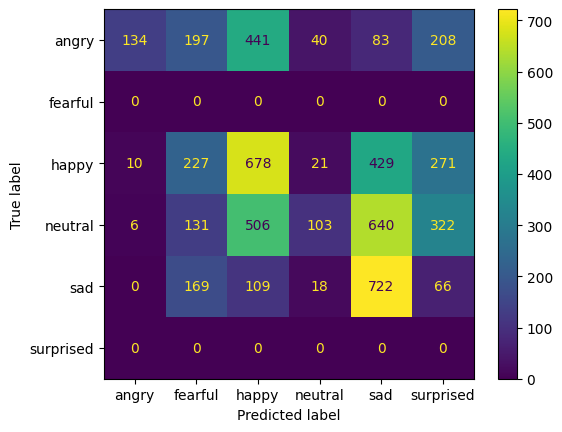

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
isPresent = [id2label[i] in ['angry', 'happy', 'neutral','sad'] for i in iomocap['label']]
a = [i for i, j in zip(true,isPresent) if j]
b = [i for i, j in zip(result_iomocap,isPresent) if j]
ConfusionMatrixDisplay.from_predictions(a,b)

In [ ]:
# Performance on Ravdess(english)- model trained on this dataset
from sklearn.metrics import classification_report
print(classification_report(rav['label'], result_rav))

              precision    recall  f1-score   support

       angry       0.95      0.98      0.97       192
        calm       0.00      0.00      0.00       192
     disgust       0.98      0.95      0.97       192
     fearful       0.94      0.98      0.96       192
       happy       0.96      0.92      0.94       192
     neutral       0.50      0.99      0.66        96
         sad       0.64      0.96      0.77       192
   surprised       0.96      0.95      0.95       192

    accuracy                           0.83      1440
   macro avg       0.74      0.84      0.78      1440
weighted avg       0.76      0.83      0.78      1440



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# performance on EMOUERJ
from sklearn.metrics import classification_report
print(classification_report(dataset['label'], result))

              precision    recall  f1-score   support

       angry       0.75      0.35      0.48        94
     fearful       0.00      0.00      0.00         0
       happy       0.48      0.31      0.38        91
     neutral       0.91      0.22      0.35        92
         sad       0.83      0.29      0.43       100
   surprised       0.00      0.00      0.00         0

    accuracy                           0.29       377
   macro avg       0.50      0.19      0.27       377
weighted avg       0.75      0.29      0.41       377



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
dataset = dataset.train_test_split(test_size=0.3)

In [ ]:
from datasets import load_dataset, Audio
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor, TrainingArguments, Trainer
import torch
id2label = {
    0: 'angry',
    1: 'disgust',
    2: 'fearful',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprised'
}
label2id = {v:k for k,v in id2label.items()}
def map_to_model_label(example):
    example["label"] = label2id[example["label"]]
    return example

dataset_ = dataset.map(map_to_model_label)

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3")

def preprocess_function(batch):
    audio = batch["audio"]
    inputs = feature_extractor(audio["array"], sampling_rate=16000)
    batch["input_features"] = inputs["input_features"][0]
    return batch

dataset = dataset_.map(preprocess_function,remove_columns=["audio"])

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

In [ ]:
import torch
from tqdm import tqdm

def compute_metrics(eval_pred):
    predictions = torch.tensor(eval_pred.predictions).argmax(-1)
    labels = torch.tensor(eval_pred.label_ids)
    accuracy = (predictions == labels).float().mean().item()
    return {"accuracy": accuracy}

# 1. Zero-shot evaluation: use the original classifier head
model = AutoModelForAudioClassification.from_pretrained(
    "firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3"
)


model.eval()
all_preds = []
all_labels = []

for example in tqdm(dataset_["test"]):
    inputs = feature_extractor(example["audio"]["array"], sampling_rate=16000, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    all_preds.append(pred)
    all_labels.append(example["label"])

accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
print(f"Zero-shot accuracy: {accuracy:.4f}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.55G [00:00<?, ?B/s]

100%|██████████| 114/114 [08:18<00:00,  4.37s/it]

Zero-shot accuracy: 0.2719


In [ ]:
training_args = TrainingArguments(
    output_dir="./ser_results_finetuned",
    per_device_train_batch_size=2,
    eval_strategy="steps",
    num_train_epochs=2,
    fp16=True,
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    report_to='none'
)

trainer_finetune = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer_finetune.train()
finetuned_results = trainer_finetune.evaluate()

/tmp/ipython-input-11-2942212052.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_finetune = Trainer(


Step,Training Loss,Validation Loss,Accuracy
50,1.761100,1.091233,0.596491
100,0.973600,2.425587,0.456140
150,1.140900,0.335293,0.903509
200,0.344000,0.392185,0.921053
250,0.123800,0.386395,0.929825


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the fut

In [ ]:
model.eval()
all_preds = []
all_labels = []

for example in tqdm(dataset_["test"]):
    inputs = feature_extractor(example["audio"]["array"], sampling_rate=16000, return_tensors="pt").to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    all_preds.append(pred)
    all_labels.append(example["label"])

accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
print(f"finetuned accuracy: {accuracy:.4f}")

100%|██████████| 114/114 [00:10<00:00, 11.15it/s]

finetuned accuracy: 0.9298


In [ ]:
a = {
    0: label2id['angry'],
    1: label2id['happy'],
    2: label2id['neutral'],
    3: label2id['sad']
 }

def map_to_label(example):
    example["label_"] = a[example["label"]]
    return example
iomocap = iomocap.map(map_to_label)

Map:   0%|          | 0/5531 [00:00<?, ? examples/s]

In [ ]:
from datasets import concatenate_datasets
#iemocap = load_dataset('Zahra99/IEMOCAP_Audio')
#iomocap = concatenate_datasets([iemocap[f'session{i}'] for i in range(1,6)])
#iomocap = iomocap.map(map_to_model_label)
all_preds = []
all_labels = []
for example in tqdm(iomocap):
    inputs = feature_extractor(example["audio"]["array"], sampling_rate=16000, return_tensors="pt").to("cuda")
    with torch.no_grad():
        logits = model_(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    all_preds.append(pred)
    all_labels.append(example["label_"])

accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
print(f"finetuned accuracy: {accuracy:.4f}")

100%|██████████| 5531/5531 [30:12<00:00,  3.05it/s]

finetuned accuracy: 0.2958


In [ ]:
rav = load_dataset("DynamicSuperb/EmotionalSpeechAudioClassification_RAVDESS-EmotionalSound", split='test')

In [ ]:
def map_rav_to_model_label(example):
    if example["label"] not in label2id:
        return None
    example["label"] = label2id[example["label"]]
    return example
rav = rav.map(map_rav_to_model_label)
rav = rav.filter(lambda x: x is not None)
all_preds = []
all_labels = []
for example in tqdm(rav):
    inputs = feature_extractor(example["audio"]["array"], sampling_rate=16000, return_tensors="pt").to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    all_preds.append(pred)
    all_labels.append(example["label"])

accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
print(f"finetuned accuracy: {accuracy:.4f}")

Map:   0%|          | 0/1248 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1248 [00:00<?, ? examples/s]

100%|██████████| 1248/1248 [01:56<00:00, 10.68it/s]

finetuned accuracy: 0.2107


# MOE EXPERIMENT

In [1]:
%%capture
!pip install -U datasets==3.6.0
!pip install fsspec==2023.9.2
!pip install torchaudio
!pip install pydub webrtcvad

In [1]:
%%capture
from datasets import load_dataset

cameo = load_dataset("amu-cai/CAMEO")

In [2]:
from datasets import concatenate_datasets
combined = None
for split in cameo.keys():
    if combined is None:
        combined = cameo[split]
    else:
        combined = concatenate_datasets([combined, cameo[split]])
combined
combined

Dataset({
    features: ['file_id', 'audio', 'emotion', 'transcription', 'speaker_id', 'gender', 'age', 'dataset', 'language', 'license'],
    num_rows: 41265
})

In [3]:
import random
def set_language_unknown(example):
  if random.random() < 0.20:
    example['language'] = 'Unknown'
  return example
combined = combined.map(set_language_unknown)

Map:   0%|          | 0/41265 [00:00<?, ? examples/s]

In [4]:
from datasets import ClassLabel
del cameo
languages = set(combined['language'])
languages = list(languages)
emotions = set(combined['emotion'])
emotions = list(emotions)
combined = combined.cast_column("language", ClassLabel(names=languages))
combined = combined.cast_column("emotion", ClassLabel(names=emotions))
combined.features

Casting the dataset:   0%|          | 0/41265 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/41265 [00:00<?, ? examples/s]

{'file_id': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None),
 'emotion': ClassLabel(names=['poker', 'surprise', 'assertiveness', 'concern', 'encouragement', 'sadness', 'happiness', 'disgust', 'apology', 'calm', 'sarcasm', 'enthusiasm', 'anger', 'excitement', 'anxiety', 'neutral', 'fear'], id=None),
 'transcription': Value(dtype='string', id=None),
 'speaker_id': Value(dtype='string', id=None),
 'gender': Value(dtype='string', id=None),
 'age': Value(dtype='string', id=None),
 'dataset': Value(dtype='string', id=None),
 'language': ClassLabel(names=['Polish', 'French', 'Unknown', 'English', 'Italian', 'Spanish', 'Russian', 'Bengali', 'German'], id=None),
 'license': Value(dtype='string', id=None)}

In [5]:
def preprocess(example):
    example["audio"] = example["audio"]["array"]
    return example

In [6]:
import random
from tqdm import tqdm
def train_val_test_split(dataset, test_size=0.15, validation_size=0.15, balance_on=None, seed=42):
    if balance_on is None:
        # Simple split
        temp_split = dataset.train_test_split(test_size=test_size + validation_size, seed=seed)
        train_dataset = temp_split["train"]
        test_val_split = temp_split["test"].train_test_split(test_size=validation_size / (test_size + validation_size), seed=seed)
        val_dataset = test_val_split["train"]
        test_dataset = test_val_split["test"]
    else:
        # Group by the specified column(s)
        groups = {}
        if isinstance(balance_on, str):
            balance_on = [balance_on]

        for i in tqdm(range(len(dataset))):
            example = dataset[i]
            key = tuple(example[col] for col in balance_on)
            if key not in groups:
                groups[key] = []
            groups[key].append(i)

        train_indices = []
        val_indices = []
        test_indices = []

        for key, indices in tqdm(groups.items()):
            random.seed(seed)
            random.shuffle(indices)
            n_total = len(indices)
            n_test = int(test_size * n_total)
            n_val = int(validation_size * n_total)
            n_train = n_total - n_test - n_val

            train_indices.extend(indices[:n_train])
            val_indices.extend(indices[n_train:n_train + n_val])
            test_indices.extend(indices[n_train + n_val:])

        train_dataset = dataset.select(train_indices)
        val_dataset = dataset.select(val_indices)
        test_dataset = dataset.select(test_indices)

    return train_dataset, val_dataset, test_dataset

train_ds, val_ds, test_ds = train_val_test_split(combined, test_size=0.2, validation_size=0.1, balance_on=['speaker_id', 'emotion', 'language'], seed=42)

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

print("Train dataset size:", len(train_ds))
print("Validation dataset size:", len(val_ds))
print("Test dataset size:", len(test_ds))

100%|██████████| 5448/5448 [00:00<00:00, 93682.50it/s]


Map:   0%|          | 0/32348 [00:00<?, ? examples/s]

Map:   0%|          | 0/2635 [00:00<?, ? examples/s]

Map:   0%|          | 0/6282 [00:00<?, ? examples/s]

Train dataset size: 32348
Validation dataset size: 2635
Test dataset size: 6282


In [7]:
import torch
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
from transformers import AutoModel, AutoFeatureExtractor


class GatingNetwork(nn.Module):

    def __init__(self, hidden, num_experts):
        super().__init__()
        self.fc1 = nn.Linear(hidden, hidden//2)
        self.fc2 = nn.Linear(hidden//2, num_experts)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

class Expert(nn.Module):

    def __init__(self, hidden, num_classes):
        super().__init__()
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        return self.fc(x)

class MoELangSER(nn.Module, PyTorchModelHubMixin, pipeline_tag='audio-classification'):

    def __init__(self, num_experts, num_classes, num_langs):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("microsoft/wavlm-base")
        #self.encoder = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-xls-r-300m")
        hidden = self.encoder.config.hidden_size
        self.lang_emb = nn.Embedding(num_langs, hidden,padding_idx=0)
        self.gate = GatingNetwork(hidden, num_experts)
        self.experts = nn.ModuleList([Expert(hidden, num_classes) for _ in range(num_experts)])
        # for p in self.encoder.parameters():
        #     p.requires_grad = False

    def forward(self, input_values, lang_ids, attention_mask=None):
        h = self.encoder(input_values, attention_mask=attention_mask).last_hidden_state
        pooled = h.mean(dim=1) + self.lang_emb(lang_ids)
        w = self.gate(pooled)
        top1 = w.argmax(dim=1)
        logit_stack = torch.stack([e(pooled) for e in self.experts], dim=1)
        out = logit_stack[torch.arange(pooled.size(0)), top1]
        if self.training:
            return out, w
        return out

#processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")
processor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base")
model = MoELangSER(num_experts=len(languages) + 1, num_classes=len(emotions), num_langs=len(languages)).to("cuda")

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
crit = nn.CrossEntropyLoss()

In [9]:
train_ds

Dataset({
    features: ['file_id', 'audio', 'emotion', 'transcription', 'speaker_id', 'gender', 'age', 'dataset', 'language', 'license'],
    num_rows: 32348
})

In [10]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def collate_fn(batch):
    audio_arrays = [item["audio"] for item in batch]
    # 2) processor pads & returns tensors
    inputs = processor(audio_arrays,
                       sampling_rate=16000,
                       padding=True,
                       return_attention_mask=False,
                       return_tensors="pt",)
    # 3) stack labels & langs
    labels   = torch.tensor([item["emotion"]  for item in batch], dtype=torch.long)
    lang_ids = torch.tensor([item["language"] for item in batch], dtype=torch.long)
    return {
      "input_values":   inputs['input_values'],
      "labels":         labels,
      "lang_id":        lang_ids
    }

train_loader = DataLoader(
    train_ds.shuffle(),
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate(model, data_loader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            iv = batch["input_values"].to(device)
            lid = batch["lang_id"].to(device)
            lbl = batch["labels"].to(device)

            logits = model(iv, lid)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(lbl.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec}

validation_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)
metrics = evaluate(model, validation_loader)
print(metrics)

In [12]:
def train(train_loader, validation_loader=None, epochs=3, eps=1e-8, lambda_balance=0.5):
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
        for batch in progress_bar:
            iv    = batch["input_values"].cuda()
            lid   = batch["lang_id"].cuda()
            lbl   = batch["labels"].cuda()

            logits, gate_w = model(iv, lid)

            loss_ce = crit(logits, lbl)
            mean_w = gate_w.mean(dim=0)
            loss_balance = - (mean_w * torch.log(mean_w + eps)).sum()
            loss = loss_ce + lambda_balance * loss_balance

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        tqdm.write(f"Epoch {epoch + 1} average loss: {epoch_loss / len(train_loader)}")
        if validation_loader:
            print(f"Epoch {epoch + 1}:", evaluate(model, validation_loader))

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [14]:
train(train_loader)

Epoch 1: 100%|██████████| 4044/4044 [25:15<00:00,  2.67it/s, loss=1.09]


Epoch 1 average loss: 1.4122719159727486


Epoch 2: 100%|██████████| 4044/4044 [25:33<00:00,  2.64it/s, loss=0.763]


Epoch 2 average loss: 0.7316650162173691


Epoch 3: 100%|██████████| 4044/4044 [25:39<00:00,  2.63it/s, loss=0.927]

Epoch 3 average loss: 0.5306983267986073


In [15]:
testloader = DataLoader(
    test_ds.shuffle(),
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)
print(evaluate(model, testloader))

100%|██████████| 393/393 [03:52<00:00,  1.69it/s]

{'accuracy': 0.7976758993950971, 'precision': 0.7098848075655058, 'recall': 0.6963062034801368}


In [16]:
print(str(emotions))

['poker', 'surprise', 'assertiveness', 'concern', 'encouragement', 'sadness', 'happiness', 'disgust', 'apology', 'calm', 'sarcasm', 'enthusiasm', 'anger', 'excitement', 'anxiety', 'neutral', 'fear']


In [17]:
# @title Test on IEMOCAP without finetuning
iemocap = load_dataset('Zahra99/IEMOCAP_Audio')
iomocap = iemocap['session5']
a = {
    0: emotions.index('anger'),
    1: emotions.index('happiness'),
    2: emotions.index('neutral'),
    3: emotions.index('sadness')
 }
def add_language_tag(example):
    example["language"] = languages.index('English')
    example["emotion"] = a[example["label"]]
    return example

iomocap = iomocap.map(add_language_tag)
iomocap = iomocap.map(preprocess)
iomocap_loader = DataLoader(iomocap, batch_size=16, shuffle=False, collate_fn=collate_fn)
print(evaluate(model, iomocap_loader))

README.md:   0%|          | 0.00/915 [00:00<?, ?B/s]

(…)-00000-of-00001-04e11ca668d90573.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

(…)-00000-of-00001-f6132100b374cb18.parquet:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)-00000-of-00001-6e102fcb5c1126b4.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

(…)-00000-of-00001-e39531a7c694b50d.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

(…)-00000-of-00001-03769060403172ce.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

Generating session1 split:   0%|          | 0/1085 [00:00<?, ? examples/s]

Generating session2 split:   0%|          | 0/1023 [00:00<?, ? examples/s]

Generating session3 split:   0%|          | 0/1151 [00:00<?, ? examples/s]

Generating session4 split:   0%|          | 0/1031 [00:00<?, ? examples/s]

Generating session5 split:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

100%|██████████| 78/78 [00:57<00:00,  1.35it/s]

{'accuracy': 0.42868654311039484, 'precision': 0.21931620278015265, 'recall': 0.16989267735066058}


In [18]:
str(languages)

"['Polish', 'French', 'Unknown', 'English', 'Italian', 'Spanish', 'Russian', 'Bengali', 'German']"

In [19]:
rav = load_dataset("DynamicSuperb/EmotionalSpeechAudioClassification_RAVDESS-EmotionalSound",split='test')
a = {
    'angry': emotions.index('anger'),
    'happy': emotions.index('happiness'),
    'neutral': emotions.index('neutral'),
    'sad': emotions.index('sadness'),
    'fearful': emotions.index('fear'),
    'disgust': emotions.index('disgust'),
    'surprised': emotions.index('surprise'),
    'calm': emotions.index('calm')
 }
def add_language_tag(example):
    example["language"] = languages.index('English')
    example["emotion"] = a[example["label"]]
    return example
rav = rav.map(add_language_tag)
rav = rav.map(preprocess)
rav_loader = DataLoader(rav, batch_size=16, shuffle=False, collate_fn=collate_fn)
print(evaluate(model, rav_loader))

README.md:   0%|          | 0.00/415 [00:00<?, ?B/s]

(…)-00000-of-00002-6dbe3b83b4ff34fe.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

(…)-00001-of-00002-08f21148a055d01f.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

100%|██████████| 90/90 [02:20<00:00,  1.56s/it]

{'accuracy': 0.16597222222222222, 'precision': 0.1675868508848274, 'recall': 0.15559895833333334}


In [20]:
# @title Test on emoUERJ without finetuning
emo_uerj = load_dataset('AdeoyeLadele/EmoUERJ', split='train')
emo_uerj
a = {
    'angry': emotions.index('anger'),
    'happy': emotions.index('happiness'),
    'neutral': emotions.index('neutral'),
    'sad': emotions.index('sadness')
 }
def add_language_tag(example):
    example["language"] = languages.index('Unknown')
    example["emotion"] = a[example["label"]]
    return example

emo_uerj = emo_uerj.train_test_split(test_size=0.5)
emo_uerj['test'] = emo_uerj['test'].map(preprocess)
emo_uerj['test'] = emo_uerj['test'].map(add_language_tag)
emo_uerj_loader = DataLoader(emo_uerj['test'], batch_size=16, shuffle=False, collate_fn=collate_fn)
print(evaluate(model, emo_uerj_loader))

README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/377 [00:00<?, ? examples/s]

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

100%|██████████| 12/12 [00:05<00:00,  2.16it/s]

{'accuracy': 0.6084656084656085, 'precision': 0.3209870067637355, 'recall': 0.2653466712906092}


In [21]:
# @title Augmentation
import random
import numpy as np
from datasets import Dataset, Features, Value, load_dataset, Sequence, Audio, ClassLabel, concatenate_datasets
import webrtcvad
from collections import deque
from pydub import AudioSegment

combinations = ["neu_emo", "emo_neu", "neu_emo_neu", "emo_emo"]
FRAME_DURATION_MS = 30
PADDING_DURATION_MS = 30
AGGRESSIVENESS = 2

class Frame:
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset+n], timestamp, duration)
        timestamp += duration
        offset += n

def vad_collector(sample_rate, frame_duration_ms, padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = deque(maxlen=num_padding_frames)
    triggered = False
    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, s in ring_buffer if s])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                for f, _ in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, s in ring_buffer if not s])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                yield b"".join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if voiced_frames:
        yield b"".join([f.bytes for f in voiced_frames])

def apply_vad(array, sr):
    pcm16 = (array * 32767).astype(np.int16).tobytes()
    vad = webrtcvad.Vad(AGGRESSIVENESS)
    frames = list(frame_generator(FRAME_DURATION_MS, pcm16, sr))
    segments = vad_collector(sr, FRAME_DURATION_MS, PADDING_DURATION_MS, vad, frames)
    voiced = b"".join(segments)
    return np.frombuffer(voiced, np.int16).astype(np.float32) / 32767.0

def sed_record_generator(utterance_ds, speaker_field=None, seed=123):
    random.seed(seed)
    speaker_index = {}
    for ex in utterance_ds:
        emo = ex["label"]
        if emo is None:
            continue
        spk = ex.get(speaker_field, "all") if speaker_field else "all"
        speaker_index.setdefault(spk, []).append(ex)

    for spk, examples in speaker_index.items():
        neu_idx = [ex for ex in examples if ex["label"] == "neutral"]
        emo_idx = [ex for ex in examples if ex["label"] != "neutral"]
        if not neu_idx or not emo_idx:
            continue

        def sample_neu():
            return random.choice(neu_idx)

        idx = 0
        for ex in emo_idx:
            arr, sr = ex["audio"]["array"], ex["audio"]["sampling_rate"]
            arr = apply_vad(arr, sr)
            pcm = (arr * 32767).astype(np.int16)
            base_seg = AudioSegment(pcm.tobytes(), sample_width=2, frame_rate=sr, channels=1)
            emo_label = ex["label"]

            for combo in combinations:
                if combo == "neu_emo":
                    n_ex = sample_neu()
                    arrn, srn = n_ex["audio"]["array"], n_ex["audio"]["sampling_rate"]
                    arrn = apply_vad(arrn, srn)
                    pcmn = (arrn * 32767).astype(np.int16)
                    n_seg = AudioSegment(pcmn.tobytes(), sample_width=2, frame_rate=srn, channels=1)
                    e_seg = base_seg.apply_gain(n_seg.dBFS - base_seg.dBFS)
                    comb = n_seg + e_seg
                    events = emo_label

                elif combo == "emo_neu":
                    n_ex = sample_neu()
                    arrn, srn = n_ex["audio"]["array"], n_ex["audio"]["sampling_rate"]
                    arrn = apply_vad(arrn, srn)
                    pcmn = (arrn * 32767).astype(np.int16)
                    n_seg = AudioSegment(pcmn.tobytes(), sample_width=2, frame_rate=srn, channels=1)
                    n_seg = n_seg.apply_gain(base_seg.dBFS - n_seg.dBFS)
                    comb = base_seg + n_seg
                    events = emo_label

                elif combo == "neu_emo_neu":
                    n1_ex, n2_ex = sample_neu(), sample_neu()
                    arr1 = apply_vad(n1_ex["audio"]["array"], n1_ex["audio"]["sampling_rate"])
                    arr2 = apply_vad(n2_ex["audio"]["array"], n2_ex["audio"]["sampling_rate"])
                    pcm1 = (arr1 * 32767).astype(np.int16)
                    pcm2 = (arr2 * 32767).astype(np.int16)
                    n1_seg = AudioSegment(pcm1.tobytes(), sample_width=2,
                                          frame_rate=n1_ex["audio"]["sampling_rate"], channels=1)
                    n2_seg = AudioSegment(pcm2.tobytes(), sample_width=2,
                                          frame_rate=n2_ex["audio"]["sampling_rate"], channels=1)
                    e_seg = base_seg.apply_gain(n1_seg.dBFS - base_seg.dBFS)
                    n2_seg = n2_seg.apply_gain(n1_seg.dBFS - n2_seg.dBFS)
                    comb = n1_seg + e_seg + n2_seg
                    start = n1_seg.duration_seconds
                    events = emo_label

                else:  # emo_emo
                    same = [e for e in emo_idx if e["label"] == emo_label and e is not ex]
                    if not same:
                        same = [e for e in emo_idx if e["label"] == emo_label]
                    other = random.choice(same)
                    arr2, sr2 = other["audio"]["array"], other["audio"]["sampling_rate"]
                    arr2 = apply_vad(arr2, sr2)
                    pcm2 = (arr2 * 32767).astype(np.int16)
                    seg2 = AudioSegment(pcm2.tobytes(), sample_width=2, frame_rate=sr2, channels=1)
                    seg2 = seg2.apply_gain(base_seg.dBFS - seg2.dBFS)
                    comb = base_seg + seg2
                    events = emo_label

                samples = np.array(comb.get_array_of_samples(), dtype=np.int16)
                array = samples.astype(np.float32) / 32767.0

                yield {
                    "id": f"{spk}_{idx}",
                    "audio": {
                        "array": array,
                        "sampling_rate": comb.frame_rate,
                    },
                    "label": events
                }
                idx += 1

            del base_seg

def augment_dataset(utterance_ds, speaker_field=None, seed=123):
    gen = lambda: sed_record_generator(utterance_ds, speaker_field, seed)
    features = Features({
        "id": Value("string"),
        "audio": Audio(sampling_rate=16000),
        "label": Value("string"),
    })
    return concatenate_datasets([Dataset.from_generator(gen, features=features), utterance_ds]).shuffle()

In [22]:
# @title Finetuning and testing on EmoUerj
emo_uerj['train'] = augment_dataset(emo_uerj['train'],'speaker_id')
emo_uerj['train'] = emo_uerj['train'].map(add_language_tag)
emo_uerj['train'] = emo_uerj['train'].map(preprocess)
train(DataLoader(emo_uerj['train'], batch_size=16, shuffle=True, collate_fn=collate_fn))
print(evaluate(model, emo_uerj_loader))

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/760 [00:00<?, ? examples/s]

Map:   0%|          | 0/760 [00:00<?, ? examples/s]

Epoch 1: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s, loss=0.125]


Epoch 1 average loss: 0.5614077926923832


Epoch 2: 100%|██████████| 48/48 [00:44<00:00,  1.09it/s, loss=0.0561]


Epoch 2 average loss: 0.13077968537497023


Epoch 3: 100%|██████████| 48/48 [00:43<00:00,  1.09it/s, loss=0.0161]


Epoch 3 average loss: 0.07503559618877868


100%|██████████| 12/12 [00:05<00:00,  2.20it/s]

{'accuracy': 0.8835978835978836, 'precision': 0.890625, 'recall': 0.8813723707340728}


In [23]:
# @title test finetuned with iomocap
print(evaluate(model, iomocap_loader))

100%|██████████| 78/78 [00:56<00:00,  1.38it/s]

{'accuracy': 0.540692989524577, 'precision': 0.29974223552619506, 'recall': 0.2735634698590975}


In [24]:
# @title test finetuned with ravdess
print(evaluate(model, rav_loader))

100%|██████████| 90/90 [02:19<00:00,  1.56s/it]

{'accuracy': 0.15833333333333333, 'precision': 0.1539667043343319, 'recall': 0.14843750000000003}


In [ ]:
model.push_to_hub('xls-r-300m-moe-ser')

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AdeoyeLadele/xls-r-300m-moe-ser/commit/6785b033dcafd497726b75a64f54259d9483ec0b', commit_message='Push model using huggingface_hub.', commit_description='', oid='6785b033dcafd497726b75a64f54259d9483ec0b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AdeoyeLadele/xls-r-300m-moe-ser', endpoint='https://huggingface.co', repo_type='model', repo_id='AdeoyeLadele/xls-r-300m-moe-ser'), pr_revision=None, pr_num=None)

In [ ]:
from datasets import concatenate_datasets, load_dataset
dataset = load_dataset("Zahra99/IEMOCAP_Audio")
CLASS_NAMES = ['ang', 'hap', 'neu', 'sad']
LABEL_MAP = dict(zip(CLASS_NAMES, range(len(CLASS_NAMES))))
id2label = {0: 'ang', 1: 'hap', 2: 'neu', 3: 'sad'}
sed_ds = prepare_sed_dataset(concatenate_datasets([dataset[f'session{i}'] for i in range(1,6)]), id2label, speaker_field=None, seed=42)
sed_ds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'array', 'sampling_rate', 'duration', 'emotion'],
    num_rows: 15292
})

In [ ]:
dataset

DatasetDict({
    session1: Dataset({
        features: ['audio', 'label'],
        num_rows: 1085
    })
    session2: Dataset({
        features: ['audio', 'label'],
        num_rows: 1023
    })
    session3: Dataset({
        features: ['audio', 'label'],
        num_rows: 1151
    })
    session4: Dataset({
        features: ['audio', 'label'],
        num_rows: 1031
    })
    session5: Dataset({
        features: ['audio', 'label'],
        num_rows: 1241
    })
})